# Data Preprocessing

## Goal is to create the directory structure:


```
data/
├── all_labels.csv
├── CVC-ClinicDB/
│   ├── test/
│   │   └── img_CVC-ClinicDB_test.png
│   ├── train/
│   │   └── img_CVC-ClinicDB_train.png
│   └── validation/
│       └── img_CVC-ClinicDB_validation.png
├── ETIS-LaribPolypDB/
│   └── test/
│       └── img_ETIS-LaribPolypDB_test.png
├── Kaidong/
│   ├── test/
│   │   └── img_Kaidong_test.png
│   ├── train/
│   │   └── img_Kaidong_train.png
│   └── validation/
│       └── img_Kaidong_validation.png
├── Kvasir/
│   ├── test/
│   │   └── img_Kvasir_test.png
│   ├── train/
│   │   └── img_Kvasir_train.png
│   └── validation/
│       └── img_Kvasir_validation.png
└── Piccolo/
    ├── test/
    │   └── img_Piccolo_test.png
    ├── train/
    │   └── img_Piccolo_train.png
    └── validation/
        └── img_Piccolo_validation.png
```

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import skimage.io as io
import matplotlib.pyplot as plt
import glob as glob
import torch


In [197]:
# Data directory during image processing stage
DATA_DIR = 'data/data' 
CVC_CLINICDB_DIR = os.path.join(DATA_DIR, 'CVC-ClinicDB')
KAIDONG_DIR = os.path.join(DATA_DIR, 'Kaidong')
PICCOLO_DIR = os.path.join(DATA_DIR, 'Piccolo')
ETIS_DIR = os.path.join(DATA_DIR, 'ETIS-LaribPolypDB')
KVASIR_DIR = os.path.join(DATA_DIR, 'Kvasir')

## Start with Kaidong

In [132]:
df_kai_train = pd.read_csv(os.path.join(KAIDONG_DIR, 'train/train_labels.csv'))
df_kai_test = pd.read_csv(os.path.join(KAIDONG_DIR, 'test/test_labels.csv'))
df_kai_validation = pd.read_csv(os.path.join(KAIDONG_DIR, 'validation/val_labels.csv'))

In [133]:
kaidong_test_dir = os.path.join('Kaidong', 'test', 'images')
kaidong_train_dir = os.path.join('Kaidong', 'train', 'images')
kaidong_validation_dir = os.path.join('Kaidong', 'validation', 'images')

In [134]:
df_kai_train['path'] = df_kai_train['filename'].apply(lambda x: os.path.join(kaidong_train_dir, x))
# df_kai_train.set_index('filename', inplace=True)
df_kai_test['path'] = df_kai_test['filename'].apply(lambda x: os.path.join(kaidong_test_dir, x))
# df_kai_test.set_index('filename', inplace=True)
df_kai_validation['path'] = df_kai_validation['filename'].apply(lambda x: os.path.join(kaidong_validation_dir, x))
# df_kai_validation.set_index('filename', inplace=True)

In [135]:
df = pd.concat([df_kai_train, df_kai_test, df_kai_validation])

In [137]:
df.to_csv('data/data/Kaidong.csv')

## Piccolo

In [140]:
all_test_masks = glob.glob(os.path.join(PICCOLO_DIR, 'test', 'masks', '*.tif'))

In [143]:
mmask = io.imread(all_test_masks[4])

In [146]:
np.max(mmask)

255

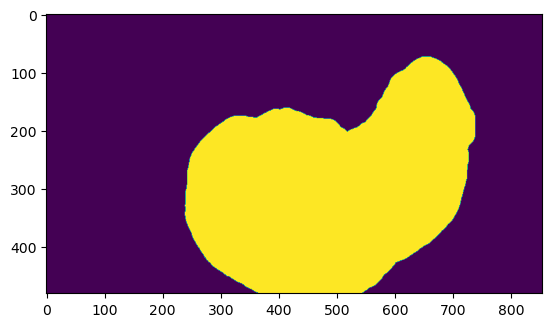

In [145]:
plt.imshow(mmask)

In [162]:

mmask = mmask / np.max(mmask)
num_objs = len(np.unique(mask))
boxes = []
for i in range(1, num_objs):
    pos = np.where(mmask == i)
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    box = (xmin, ymin, xmax, ymax)
    boxes.append(box)
boxes = np.asarray(boxes, dtype=np.float32)

In [163]:
boxes

array([[239.,  73., 738., 479.]], dtype=float32)

In [172]:
all_imgs = glob.glob(os.path.join(PICCOLO_DIR, '*', 'images', '*.png'))
all_masks = glob.glob(os.path.join(PICCOLO_DIR, '*', 'masks', '*.tif'))

In [156]:
all_imgs[0].split('/')[-1].split('.')[0]

'011_VP9_frame0071'

In [179]:
piccolo_dict = {'filename': [], 'path': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'width': [], 'height': []}

In [181]:
bad_images = []

In [182]:
for i in all_imgs:
    j = os.path.join(PICCOLO_DIR, i.split('/')[-3], 'masks', i.split('/')[-1].split('.')[0] + '_Corrected.tif')
    img = io.imread(i)
    width = img.shape[1]
    height = img.shape[0]
    filename = i.split('/')[-1]
    path = i
    mask = io.imread(j)
    if np.max(mask) == 0:
        bad_images.append({'filename': filename, 'path': path, 'mask': j})
        print(f'bad image: {filename=}, {path=}, mask={j}')
        continue
    mask = mask / np.max(mask)
    num_objs = len(np.unique(mask))
    for i in range(1, num_objs):
        pos = np.where(mask == i)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        piccolo_dict['filename'].append(filename)
        piccolo_dict['path'].append(path)
        piccolo_dict['xmin'].append(xmin)
        piccolo_dict['ymin'].append(ymin)
        piccolo_dict['xmax'].append(xmax)
        piccolo_dict['ymax'].append(ymax)
        piccolo_dict['class'].append(1)
        piccolo_dict['width'].append(width)
        piccolo_dict['height'].append(height)

    

bad image: filename='054_VP48_frame0033.png', path='data/data/Piccolo/train/images/054_VP48_frame0033.png', mask=data/data/Piccolo/train/masks/054_VP48_frame0033_Corrected.tif
bad image: filename='032_VP30_frame2942.png', path='data/data/Piccolo/train/images/032_VP30_frame2942.png', mask=data/data/Piccolo/train/masks/032_VP30_frame2942_Corrected.tif
bad image: filename='020_VP22_frame3899.png', path='data/data/Piccolo/train/images/020_VP22_frame3899.png', mask=data/data/Piccolo/train/masks/020_VP22_frame3899_Corrected.tif
bad image: filename='020_VP22_frame4311.png', path='data/data/Piccolo/train/images/020_VP22_frame4311.png', mask=data/data/Piccolo/train/masks/020_VP22_frame4311_Corrected.tif
bad image: filename='054_VP48_frame0814.png', path='data/data/Piccolo/train/images/054_VP48_frame0814.png', mask=data/data/Piccolo/train/masks/054_VP48_frame0814_Corrected.tif
bad image: filename='054_VP48_frame0790.png', path='data/data/Piccolo/train/images/054_VP48_frame0790.png', mask=data/da

In [183]:
for i in bad_images:
    piccolo_dict['filename'].append(i['filename'])
    piccolo_dict['path'].append(i['path'])
    piccolo_dict['xmin'].append(1)
    piccolo_dict['ymin'].append(1)
    piccolo_dict['xmax'].append(3)
    piccolo_dict['ymax'].append(3)
    piccolo_dict['class'].append(0)
    piccolo_dict['width'].append(0)
    piccolo_dict['height'].append(0)

In [184]:
df_piccolo = pd.DataFrame(piccolo_dict)

In [186]:
df_piccolo.to_csv('data/data/Piccolo.csv')

## CVC-ClinicDB

In [187]:
all_imgs = glob.glob(os.path.join(CVC_CLINICDB_DIR, '*', 'images', '*.png'))

In [188]:
cvc_clinicdb_dict = {'filename': [], 'path': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'width': [], 'height': []}

In [192]:
for i in all_imgs:
    j = os.path.join(CVC_CLINICDB_DIR, i.split('/')[-3], 'masks', i.split('/')[-1])
    img = io.imread(i)
    width = img.shape[1]
    height = img.shape[0]
    filename = i.split('/')[-1]
    path = i
    mask = io.imread(j)
    mask[mask < 255] = 0
    mask = mask / np.max(mask)
    num_objs = len(np.unique(mask))
    for i in range(1, num_objs):
        pos = np.where(mask == i)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        cvc_clinicdb_dict['filename'].append(filename)
        cvc_clinicdb_dict['path'].append(path)
        cvc_clinicdb_dict['xmin'].append(xmin)
        cvc_clinicdb_dict['ymin'].append(ymin)
        cvc_clinicdb_dict['xmax'].append(xmax)
        cvc_clinicdb_dict['ymax'].append(ymax)
        cvc_clinicdb_dict['class'].append(1)
        cvc_clinicdb_dict['width'].append(width)
        cvc_clinicdb_dict['height'].append(height)

In [193]:
df_cvc_clinicdb = pd.DataFrame(cvc_clinicdb_dict)

In [196]:
df_cvc_clinicdb.to_csv('data/data/CVC_ClinicDB.csv')

## Kvasir

In [198]:
all_imgs = glob.glob(os.path.join(KVASIR_DIR, '*', 'images', '*.png'))

In [199]:
all_masks = glob.glob(os.path.join(KVASIR_DIR, '*', 'masks', '*.png'))

In [200]:
mask = io.imread(all_masks[0])

In [202]:
np.unique(mask)

array([  0,   1,   2,   3,   4,   5,   6,   7, 248, 249, 250, 251, 252,
       253, 254, 255], dtype=uint8)

In [203]:
kvasir_dict = {'filename': [], 'path': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'width': [], 'height': []}

In [204]:
for i in all_imgs:
    j = os.path.join(KVASIR_DIR, i.split('/')[-3], 'masks', i.split('/')[-1])
    img = io.imread(i)
    width = img.shape[1]
    height = img.shape[0]
    filename = i.split('/')[-1]
    path = i
    mask = io.imread(j)
    mask[mask < 255] = 0
    mask = mask / np.max(mask)
    num_objs = len(np.unique(mask))
    for i in range(1, num_objs):
        pos = np.where(mask == i)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        kvasir_dict['filename'].append(filename)
        kvasir_dict['path'].append(path)
        kvasir_dict['xmin'].append(xmin)
        kvasir_dict['ymin'].append(ymin)
        kvasir_dict['xmax'].append(xmax)
        kvasir_dict['ymax'].append(ymax)
        kvasir_dict['class'].append(1)
        kvasir_dict['width'].append(width)
        kvasir_dict['height'].append(height)

In [205]:
df_kvasir = pd.DataFrame(kvasir_dict)

In [206]:
df_kvasir.head()

,filename,path,xmin,ymin,xmax,ymax,class,width,height
0,cju42qet0lsq90871e50xbnuv.png,data/data/Kvasir/train/images/cju42qet0lsq9087...,228,84,387,280,1,598,531
1,cju1fj6axwfp30835ukhuzhw9.png,data/data/Kvasir/train/images/cju1fj6axwfp3083...,0,0,575,376,1,576,547
2,cju8czvnztbf40871b4m7t78w.png,data/data/Kvasir/train/images/cju8czvnztbf4087...,118,209,400,470,1,626,546
3,cju1f320ewfyu0988ndz6blh5.png,data/data/Kvasir/train/images/cju1f320ewfyu098...,173,300,476,511,1,571,530
4,cju2r7h21sj9608354gzks3ae.png,data/data/Kvasir/train/images/cju2r7h21sj96083...,264,307,400,402,1,614,530


In [207]:
df_kvasir.describe()

,xmin,ymin,xmax,ymax,class,width,height
count,991.000000,991.000000,991.000000,991.000000,991.0,991.000000,991.000000
mean,191.434914,130.119072,469.642785,412.603431,1.0,625.007064,545.193744
std,126.795204,104.663945,130.449408,125.760166,0.0,130.058584,91.071860
min,0.000000,0.000000,157.000000,87.000000,1.0,332.000000,352.000000
25%,91.000000,37.000000,387.000000,336.000000,1.0,591.000000,529.000000
50%,202.000000,121.000000,461.000000,408.000000,1.0,621.000000,530.000000
75%,287.000000,205.000000,540.000000,487.000000,1.0,622.000000,531.000000
max,668.000000,757.000000,1347.000000,1069.000000,1.0,1920.000000,1072.000000


In [208]:
df_kvasir.to_csv('data/data/Kvasir.csv')

## ETIS

In [209]:
all_imgs = glob.glob(os.path.join(ETIS_DIR, '*', 'images', '*.png'))

In [210]:
etis_dict = {'filename': [], 'path': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'width': [], 'height': []}

In [211]:
for i in all_imgs:
    j = os.path.join(ETIS_DIR, i.split('/')[-3], 'masks', i.split('/')[-1])
    img = io.imread(i)
    width = img.shape[1]
    height = img.shape[0]
    filename = i.split('/')[-1]
    path = i
    mask = io.imread(j)
    mask[mask < 255] = 0
    mask = mask / np.max(mask)
    num_objs = len(np.unique(mask))
    for i in range(1, num_objs):
        pos = np.where(mask == i)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        etis_dict['filename'].append(filename)
        etis_dict['path'].append(path)
        etis_dict['xmin'].append(xmin)
        etis_dict['ymin'].append(ymin)
        etis_dict['xmax'].append(xmax)
        etis_dict['ymax'].append(ymax)
        etis_dict['class'].append(1)
        etis_dict['width'].append(width)
        etis_dict['height'].append(height)

In [212]:
df_etis = pd.DataFrame(etis_dict)

In [213]:
df_etis.describe()

,xmin,ymin,xmax,ymax,class,width,height
count,196.000000,196.000000,196.000000,196.000000,196.0,196.0,196.0
mean,475.852041,406.969388,737.051020,646.035714,1.0,1225.0,966.0
std,253.349973,180.379455,253.194316,177.948606,0.0,0.0,0.0
min,0.000000,2.000000,167.000000,190.000000,1.0,1225.0,966.0
25%,295.750000,288.750000,560.500000,515.750000,1.0,1225.0,966.0
50%,452.000000,398.000000,741.500000,662.500000,1.0,1225.0,966.0
75%,684.750000,509.250000,922.250000,785.000000,1.0,1225.0,966.0
max,1036.000000,819.000000,1222.000000,955.000000,1.0,1225.0,966.0


In [214]:
df_etis.to_csv('data/data/ETIS.csv')

# Combine all data frames into a single dataframe and save it as a csv file

In [215]:
df_kaidong = pd.read_csv('data/data/KaiDong.csv')
df_piccolo = pd.read_csv('data/data/Piccolo.csv')
df_cvc_clinicdb = pd.read_csv('data/data/CVC_ClinicDB.csv')
df_kvasir = pd.read_csv('data/data/Kvasir.csv')
df_etis = pd.read_csv('data/data/ETIS.csv')

df_all = pd.concat([df_kaidong, df_piccolo, df_cvc_clinicdb, df_kvasir, df_etis])

In [216]:
df_all.describe()

,Unnamed: 0,width,height,xmin,ymin,xmax,ymax,image_id
count,45118.000000,45118.000000,45118.000000,45118.000000,45118.000000,45118.000000,45118.000000,38698.000000
mean,9974.544727,642.161798,474.667383,237.865952,171.087194,414.438317,337.017133,11335.460127
std,8891.388705,295.512428,154.877307,134.528662,97.023138,265.500844,174.425531,8877.869879
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000
25%,2370.000000,544.000000,448.000000,163.000000,109.000000,302.000000,256.000000,3224.250000
50%,6213.500000,592.000000,464.000000,225.000000,169.000000,375.000000,327.000000,9423.500000
75%,17492.750000,622.000000,480.000000,289.000000,228.000000,453.000000,394.000000,19097.750000
max,28772.000000,1920.000000,1080.000000,1565.000000,961.000000,1803.000000,1079.000000,28772.000000


In [219]:
df_all.drop(columns=['image_id'], inplace=True)

In [220]:
df_all.describe()

,Unnamed: 0,width,height,xmin,ymin,xmax,ymax
count,45118.000000,45118.000000,45118.000000,45118.000000,45118.000000,45118.000000,45118.000000
mean,9974.544727,642.161798,474.667383,237.865952,171.087194,414.438317,337.017133
std,8891.388705,295.512428,154.877307,134.528662,97.023138,265.500844,174.425531
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,2370.000000,544.000000,448.000000,163.000000,109.000000,302.000000,256.000000
50%,6213.500000,592.000000,464.000000,225.000000,169.000000,375.000000,327.000000
75%,17492.750000,622.000000,480.000000,289.000000,228.000000,453.000000,394.000000
max,28772.000000,1920.000000,1080.000000,1565.000000,961.000000,1803.000000,1079.000000


In [221]:
df_all.to_csv('data/data/all_data.csv')

In [222]:
df_all['width'].count()

45118

In [1]:
from torchvision.transforms import v2 as T

/Users/jarret/opt/anaconda3/envs/bolt-hlc/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/jarret/opt/anaconda3/envs/bolt-hlc/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. 

In [1]:
# Auo reload modules
%load_ext autoreload
%autoreload 2

In [36]:
pdata = PolypsDataset(root_dir='data/data', stage='train')

In [22]:
img, target = pdata[0]

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [160]:
img, target = pdata[200]

In [165]:
img.shape

torch.Size([3, 548, 700])

In [91]:
import cv2
imgg = cv2.imread('data/data/CVC-ClinicDB/test/images/228.png')

In [94]:
imgg = cv2.cvtColor(imgg, cv2.COLOR_BGR2RGB)

In [99]:
imggg = cv2.resize(imgg, (1024, 512))

In [100]:
imggg.shape

(512, 1024, 3)

In [101]:
imgg.shape

(288, 384, 3)

In [111]:
target['labels']

tensor([], dtype=torch.int64)

In [163]:
CLASSES = ['background', 'polyp']
def visualize_sample(image, target):
    box = target["boxes"][0]
    label = CLASSES[target["labels"]]
    if label != 'background':
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), (0, 255, 0), 1
        )
    cv2.putText(
        image, 
        label, 
        (int(box[0]), int(box[1]) - 5), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
    plt.imshow(image)

In [48]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from src.PolypsDataset import PolypsDataset
from torch.utils.data import DataLoader
bbox_params = A.BboxParams(
            format='pascal_voc', 
            min_visibility=0.1, 
            min_area=128, 
            label_fields=['labels'])

train_transform = A.Compose([
            A.Flip(p=0.25),
            A.RandomRotate90(p=0.15),
            A.RandomBrightnessContrast(p=0.25),
            A.MotionBlur(p=0.5),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
            ToTensorV2(p=1.0),],
        bbox_params=bbox_params)
pdata =  PolypsDataset(root_dir='data', stage='validation', transforms=train_transform)

In [49]:
from src.utils import collate_fn

In [50]:
dl = DataLoader(pdata, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [51]:
from tqdm import tqdm_notebook as tqdm
from warnings import filterwarnings
filterwarnings("ignore")

In [52]:
for i, (images, targets) in tqdm(enumerate(dl)):
    if i % 1000 == 0:
        print(i)

0it [00:00, ?it/s]

0
1000
